> __Purpose:__ Cluster using 2D dataset of (norm, update) with the plotted labels being (condition, subject)
> Still not clear if I should just take the norm of take the norm wrt the first/last.  
> Can I make a similarity matrix? How would I use that for clustering...
<br>
<br>
> __Did not re-run with all 14 participants, the current clustering approach clearly is not sufficient__

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn
import time
import pandas as pd
import pickle
import random
from experiment_params import *

random.seed(a=1)

# Load In Data

In [3]:
# I think this entire block can be replaced with the newer code
with open('Data\cphs_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    _, _, _, _, _, Ws_block1, _, _, _, _, _ = pickle.load(handle)

#with open('Data\cphs_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    #_, _, _, _, _, Ws_block2, _, _, _, _, _ = pickle.load(handle)

In [3]:
# Decoder updates
W = Ws_block1[keys[0]][0]
W[1:,:,:].shape # 7199 time points x (decoder dimensions is 2 x 6)
dold = W[0]
update_ix = []
for ix,d in enumerate(W[1:]):
    if (np.array_equal(dold,d)==False):
        update_ix.append(ix)
        dold = d

update_ix.append(len(W) - 1) 
update_ix = np.asarray(update_ix)
update_ix = np.hstack([[0],update_ix])

num_updates = len(update_ix)

print(update_ix.shape)
print(update_ix)

(19,)
[    0  1200  2402  3604  4806  6008  7210  8412  9614 10816 12018 13220
 14422 15624 16826 18028 19230 20432 20769]


In [4]:
dec_norms_df1 = pd.read_csv("Data\decoder_full_norms1.csv")
dec_norms_df2 = pd.read_csv("Data\decoder_full_norms2.csv")

dec_norms_df = pd.concat((dec_norms_df1, dec_norms_df2))
if dec_norms_df.columns[0]=='Unnamed: 0':
    dec_norms_df.drop("Unnamed: 0", axis=1, inplace=True)

dec_norms_df.head()

,Subject,Condition,Update Number,Frobenius Norm
0,METACPHS_S106,0,0,0.066360
1,METACPHS_S106,0,1,0.066360
2,METACPHS_S106,0,2,9.709390
3,METACPHS_S106,0,3,8.209080
4,METACPHS_S106,0,4,10.406943


In [5]:
# Need to actaully assemnble the vector of norms
my_norm_vecs1 = {k: [0]*num_conditions for k in keys}
my_norm_vecs2 = {k: [0]*num_conditions for k in keys}

for key in keys:
    for i in range(num_conditions):
        my_norm_vecs1[key][i] = dec_norms_df1[(dec_norms_df1["Subject"]==key) & (dec_norms_df1["Condition"]==i)]["Frobenius Norm"]
        my_norm_vecs2[key][i] = dec_norms_df2[(dec_norms_df2["Subject"]==key) & (dec_norms_df2["Condition"]==i)]["Frobenius Norm"]

assert len(my_norm_vecs1)==len(keys)
assert len(my_norm_vecs1[keys[0]])==num_conditions
assert len(my_norm_vecs1[keys[0]][0])==num_updates

In [6]:
participant_dec1 = dec_norms_df1[dec_norms_df1["Update Number"]==0]
participant_dec1 = participant_dec1.drop(["Update Number", "Frobenius Norm", "Unnamed: 0"], axis=1)
participant_dec1.head()

,Subject,Condition
0,METACPHS_S106,0
19,METACPHS_S106,1
38,METACPHS_S106,2
57,METACPHS_S106,3
76,METACPHS_S106,4


In [9]:
# Highkey I didn't need to flatten this out lol

dec_norm_vec_df1 = pd.DataFrame()
dec_norm_vec_df2 = pd.DataFrame()

for key in keys:
    for my_cond in range(num_conds):
        test = pd.DataFrame(np.ravel(my_norm_vecs1[key][my_cond])).T
        dec_norm_vec_df1 = pd.concat((dec_norm_vec_df1, test))
        
        test = pd.DataFrame(np.ravel(my_norm_vecs2[key][my_cond])).T
        dec_norm_vec_df2 = pd.concat((dec_norm_vec_df2, test))
        
dec_norm_vec_df1.reset_index(inplace=True, drop=True)
dec_norm_vec_df1.insert(loc=0, column='Condition', value=list(participant_dec1['Condition']))
dec_norm_vec_df1.insert(loc=0, column='Subject', value=list(participant_dec1['Subject']))

# Condition orders are the same for blocks 1 and 2, thus can reuse part_dec1
dec_norm_vec_df2.reset_index(inplace=True, drop=True)
dec_norm_vec_df2.insert(loc=0, column='Condition', value=list(participant_dec1['Condition']))
dec_norm_vec_df2.insert(loc=0, column='Subject', value=list(participant_dec1['Subject']))

print(dec_norm_vec_df1.shape)
dec_norm_vec_df1.head()

(56, 21)


,Subject,Condition,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,METACPHS_S106,0,0.066360,0.066360,9.709390,8.209080,10.406943,9.580694,9.629371,11.050709,...,9.842022,11.557703,9.087193,10.045960,10.822497,14.243187,11.904018,8.777538,7.331144,6.918506
1,METACPHS_S106,1,0.066360,0.066360,9.043525,12.601582,14.098500,19.274487,10.584628,10.437300,...,14.970674,14.534948,11.418941,11.279606,16.566827,12.103410,14.068504,10.300921,23.491765,11.794499
2,METACPHS_S106,2,0.067994,0.067994,9.383530,11.684948,8.902273,9.833786,12.761645,10.369487,...,13.236316,11.292572,10.842637,10.897666,8.968215,6.936480,8.996453,7.197297,10.487608,15.107841
3,METACPHS_S106,3,0.067994,0.067994,12.956790,23.473156,15.873840,12.714750,20.152452,18.975033,...,17.667470,16.598130,15.585882,15.199927,19.719565,11.285932,14.525372,23.137891,18.963112,17.084898
4,METACPHS_S106,4,0.066360,0.066360,1.700615,3.311166,3.092765,3.279701,3.910120,3.260317,...,2.576059,2.781573,2.906166,2.593664,3.129468,2.875563,3.631470,3.389547,3.486817,3.679429


## 1) Linking Matrix Norms to Participants

In [ ]:
update_x_axis = np.array(range(19))

key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

FOR THE FIRST SUBJECT

In [10]:
example_df = dec_norm_vec_df1[dec_norm_vec_df1['Subject']==keys[0]]

print(example_df.shape)
example_df.head()

(8, 21)


,Subject,Condition,0,1,2,3,4,5,6,7,...,9,10,11,12,13,14,15,16,17,18
0,METACPHS_S106,0,0.066360,0.066360,9.709390,8.209080,10.406943,9.580694,9.629371,11.050709,...,9.842022,11.557703,9.087193,10.045960,10.822497,14.243187,11.904018,8.777538,7.331144,6.918506
1,METACPHS_S106,1,0.066360,0.066360,9.043525,12.601582,14.098500,19.274487,10.584628,10.437300,...,14.970674,14.534948,11.418941,11.279606,16.566827,12.103410,14.068504,10.300921,23.491765,11.794499
2,METACPHS_S106,2,0.067994,0.067994,9.383530,11.684948,8.902273,9.833786,12.761645,10.369487,...,13.236316,11.292572,10.842637,10.897666,8.968215,6.936480,8.996453,7.197297,10.487608,15.107841
3,METACPHS_S106,3,0.067994,0.067994,12.956790,23.473156,15.873840,12.714750,20.152452,18.975033,...,17.667470,16.598130,15.585882,15.199927,19.719565,11.285932,14.525372,23.137891,18.963112,17.084898
4,METACPHS_S106,4,0.066360,0.066360,1.700615,3.311166,3.092765,3.279701,3.910120,3.260317,...,2.576059,2.781573,2.906166,2.593664,3.129468,2.875563,3.631470,3.389547,3.486817,3.679429


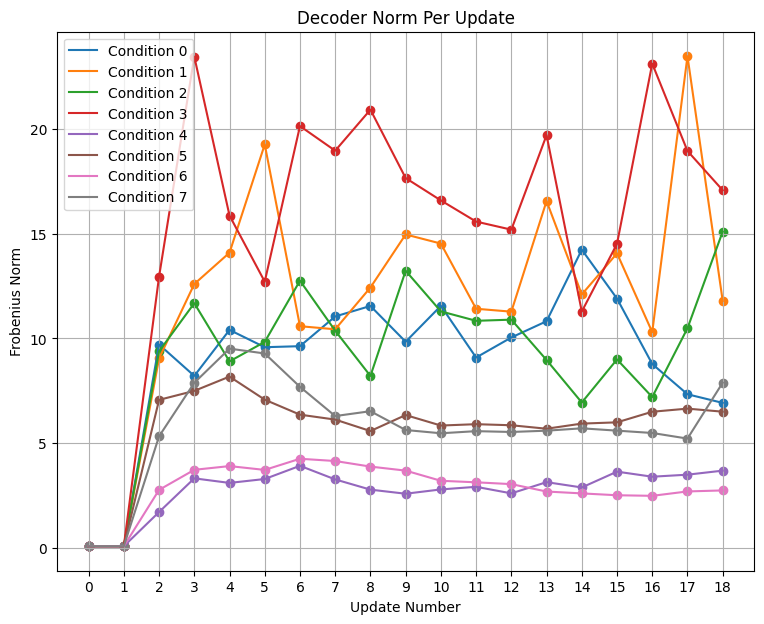

In [53]:
plt.figure(figsize=(9,7))
for i in range(example_df.shape[0]):
    plt.plot(update_x_axis, example_df.iloc[i, 2:], label=("Condition "+str(i)))
    plt.scatter(update_x_axis, example_df.iloc[i, 2:])
plt.title("Decoder Norm Per Update")
plt.legend(loc='best')
plt.xlabel("Update Number")
plt.ylabel("Frobenius Norm")
plt.xticks(np.arange(0, 19, 1.0))
#plt.yticks(np.arange(0, 26, 3))
plt.grid() 
plt.show()

FOR THE FIRST CONDITION

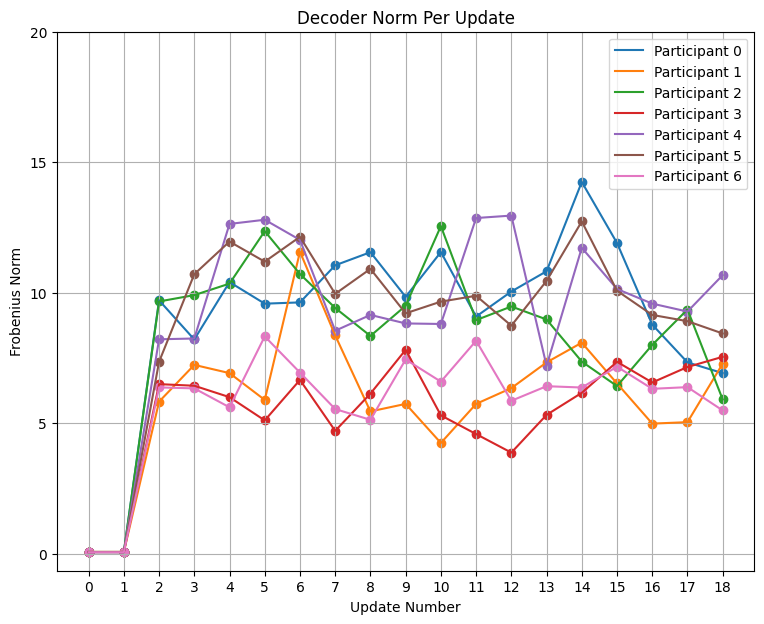

In [66]:
example_df = dec_norm_vec_df1[dec_norm_vec_df1['Condition']==0]

plt.figure(figsize=(9,7))
for i in range(example_df.shape[0]):
    plt.plot(update_x_axis, example_df.iloc[i, 2:], label=("Participant "+str(i)))
    plt.scatter(update_x_axis, example_df.iloc[i, 2:])
plt.title("Decoder Norm Per Update")
plt.legend(loc='best')
plt.xlabel("Update Number")
plt.ylabel("Frobenius Norm")
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 25, 5))
plt.grid() 
plt.show()

FOR THE 3rd CONDITION

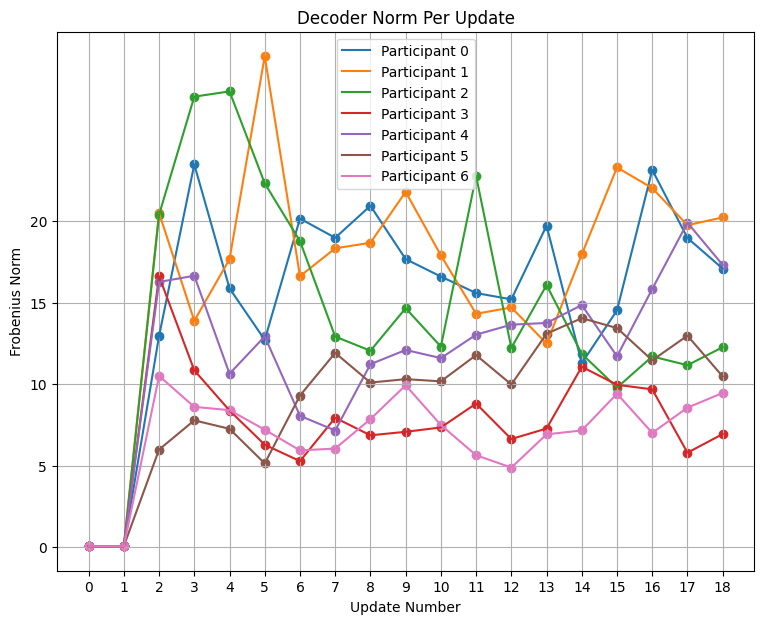

In [67]:
example_df = dec_norm_vec_df1[dec_norm_vec_df1['Condition']==3]

plt.figure(figsize=(9,7))
for i in range(example_df.shape[0]):
    plt.plot(update_x_axis, example_df.iloc[i, 2:], label=("Participant "+str(i)))
    plt.scatter(update_x_axis, example_df.iloc[i, 2:])
plt.title("Decoder Norm Per Update")
plt.legend(loc='best')
plt.xlabel("Update Number")
plt.ylabel("Frobenius Norm")
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 25, 5))
plt.grid() 
plt.show()

FOR THE 5th CONDITION

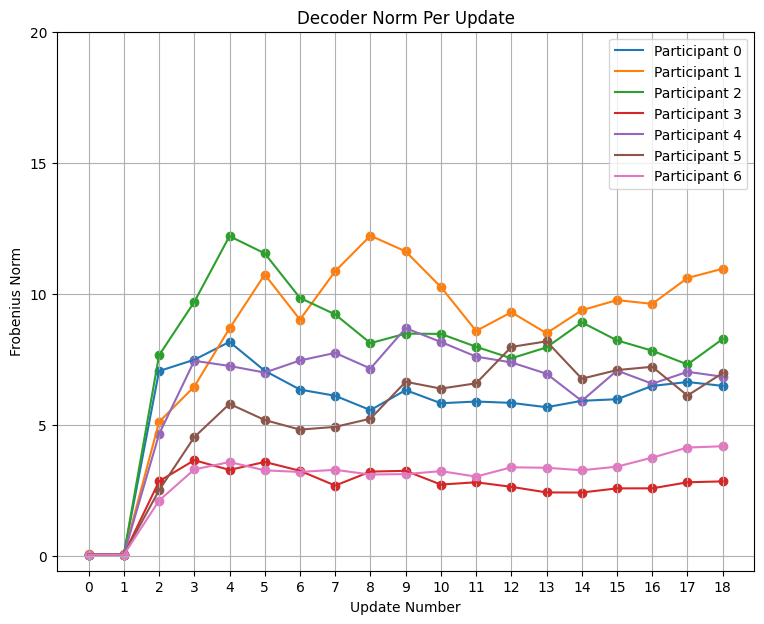

In [68]:
example_df = dec_norm_vec_df1[dec_norm_vec_df1['Condition']==5]

plt.figure(figsize=(9,7))
for i in range(example_df.shape[0]):
    plt.plot(update_x_axis, example_df.iloc[i, 2:], label=("Participant "+str(i)))
    plt.scatter(update_x_axis, example_df.iloc[i, 2:])
plt.title("Decoder Norm Per Update")
plt.legend(loc='best')
plt.xlabel("Update Number")
plt.ylabel("Frobenius Norm")
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 25, 5))
plt.grid() 
plt.show()

FOR THE LAST CONDITION

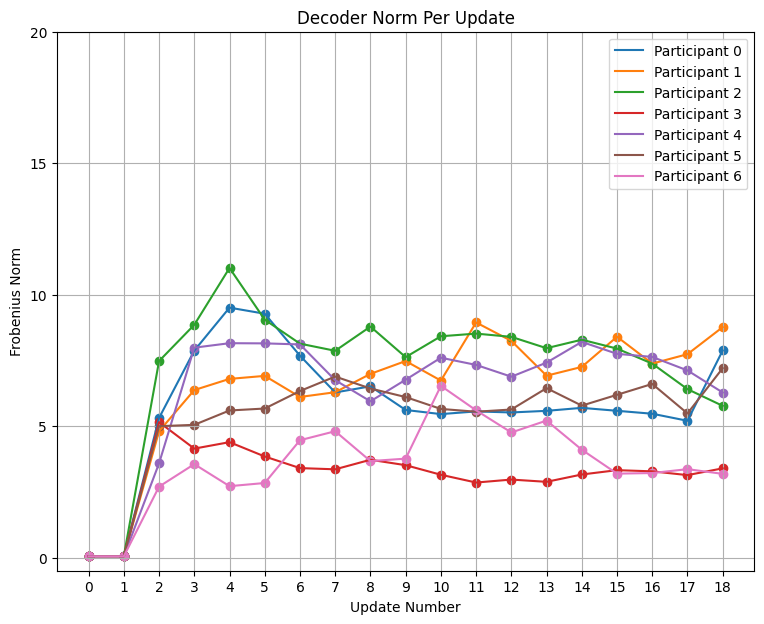

In [64]:
example_df = dec_norm_vec_df1[dec_norm_vec_df1['Condition']==7]

plt.figure(figsize=(9,7))
for i in range(example_df.shape[0]):
    plt.plot(update_x_axis, example_df.iloc[i, 2:], label=("Participant "+str(i)))
    plt.scatter(update_x_axis, example_df.iloc[i, 2:])
plt.title("Decoder Norm Per Update")
plt.legend(loc='best')
plt.xlabel("Update Number")
plt.ylabel("Frobenius Norm")
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 25, 5))
plt.grid() 
plt.show()

## 2) Cluster Decoder Matrix Norms
> Cluster using 2D dataset of (norm, condition), condition being the y axis maybe?
> Still not sure if I should just take the norm of take the norm wrt the first/last.  
> Can I make a similarity matrix? How would I use that for clustering...
> Save this idea for later... clustering is just another form of an attack vector, the ML model above already was successful